## Generative pretrained image priors 

This notebook is an example for the installation of spreco and generation of images with it.

In [ ]:
%%bash
git clone https://github.com/mrirecon/spreco
cd spreco
pip install .
pip install huggingface_hub

In [1]:
from huggingface_hub import hf_hub_download

smld = ["config.yaml", "smld.data-00000-of-00001", "smld.index", "smld.meta"]
cplx_large = ["config.yaml", "pixelcnn.data-00000-of-00001", "pixelcnn.index", "pixelcnn.meta"]

for file in smld:
    hf_hub_download(repo_id="Guanxiong/MRI-Image-Priors", subfolder="Diffusion/SMLD", filename=file, local_dir="./")

for file in cplx_large:
    hf_hub_download(repo_id="Guanxiong/MRI-Image-Priors", subfolder="PixelCNN/cplx_large", filename=file, local_dir="./")

#### Generate MR images with the downloaded model
The cell below will take much longer than the above as the generation needs many iterations. Just let it go for around 20mins with a T4 accelerator on Colab, then come back. You will get 25 brain images that have a size of (256,256).

In [2]:
from spreco.common import utils
from spreco.sampler import sampler
import numpy as np

log_path   = './Diffusion/SMLD'
model_path = log_path+'/smld'
config     = utils.load_config(log_path+'/config.yaml')

N=100
sigma_type='quad'
target_snr=0.2
print("INFO -> sigma type: %s, sigma max: %.4f, simga min: %.4f, discrete steps: %d "%( sigma_type, config['sigma_max'], config['sigma_min'], N))

config['N'] = N
a_sampler = sampler(config, target_snr, sigma_type)
a_sampler.init_sampler(model_path, gpu_id='0')

2023-08-14 13:19:24.692257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 13:19:30.731940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO -> sigma type: quad, sigma max: 5.0000, simga min: 0.0010, discrete steps: 100 


2023-08-14 13:19:57.002499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79112 MB memory:  -> device: 0, name: A100-SXM-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2023-08-14 13:19:57.299569: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Restoring parameters from ./Diffusion/SMLD/smld


In [4]:
#### Create a function to plot the grid of images

%matplotlib inline
import matplotlib.pyplot as plt
from functools import partial

def subplot(ax, img, title, cmap, interpolation, vmin, vmax):
    ax.imshow(img, cmap=cmap, interpolation=interpolation, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

plot_params = {'cmap': 'gray', 'interpolation': 'none', 'vmin': 0}
axplot      = partial(subplot, **plot_params)

#### Predictor-and-corrector sampling 

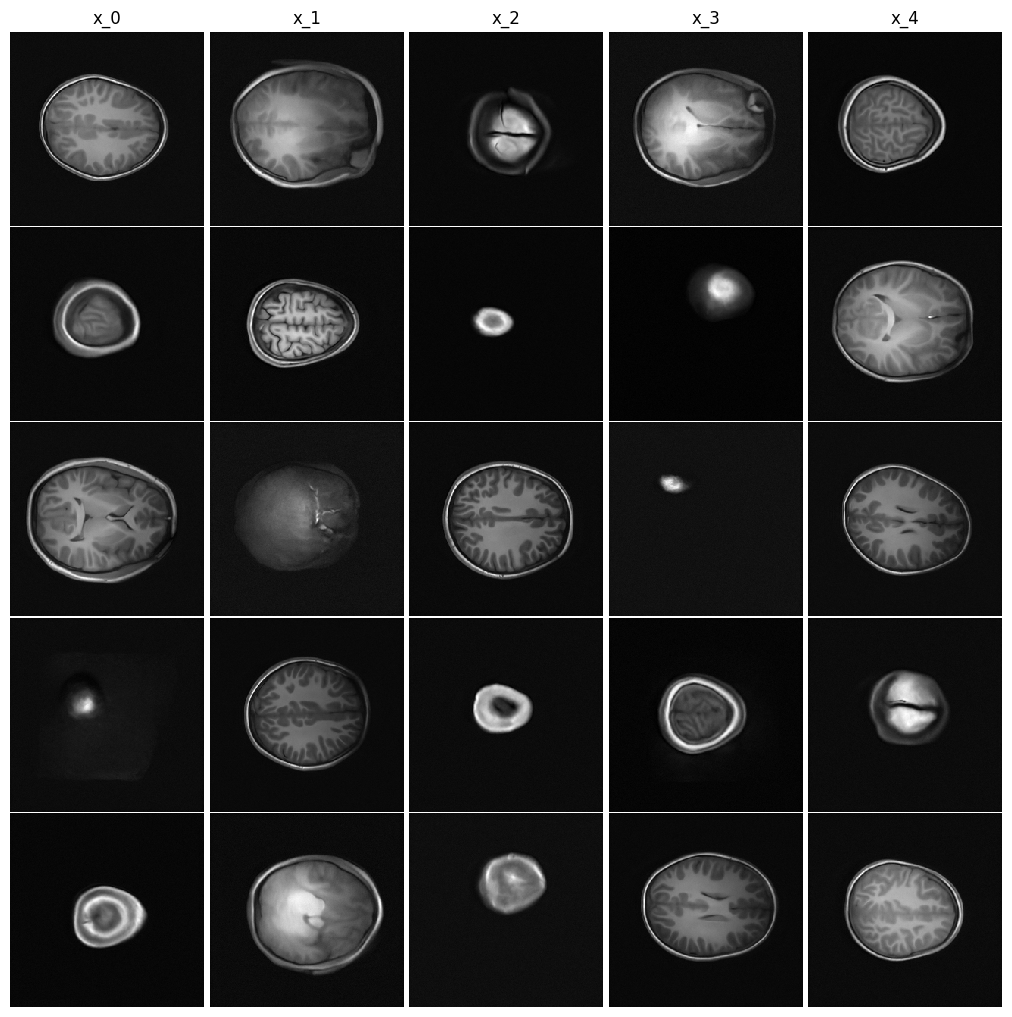

In [7]:
%matplotlib inline
grid_x=5
grid_y=5
samples_n, samples  = a_sampler.pc_sampler(grid_x*grid_y, 3)

images = samples_n[-1]
images = np.abs(utils.float2cplx(images))

fig, axss = plt.subplots(grid_x, grid_y, figsize=(10, 10), gridspec_kw={'width_ratios': [1  for _ in range(grid_x)]})
for i in range(grid_x):
    for j in range(grid_y):
        if i==0:
            strs='x_%d'%j
        else:
            strs=''
        axplot(axss[i,j], images[i*grid_y+j], title=strs, vmax=np.max(images[i*grid_y+j]))
plt.tight_layout(pad=.1)

#### Ancestral sampling

100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


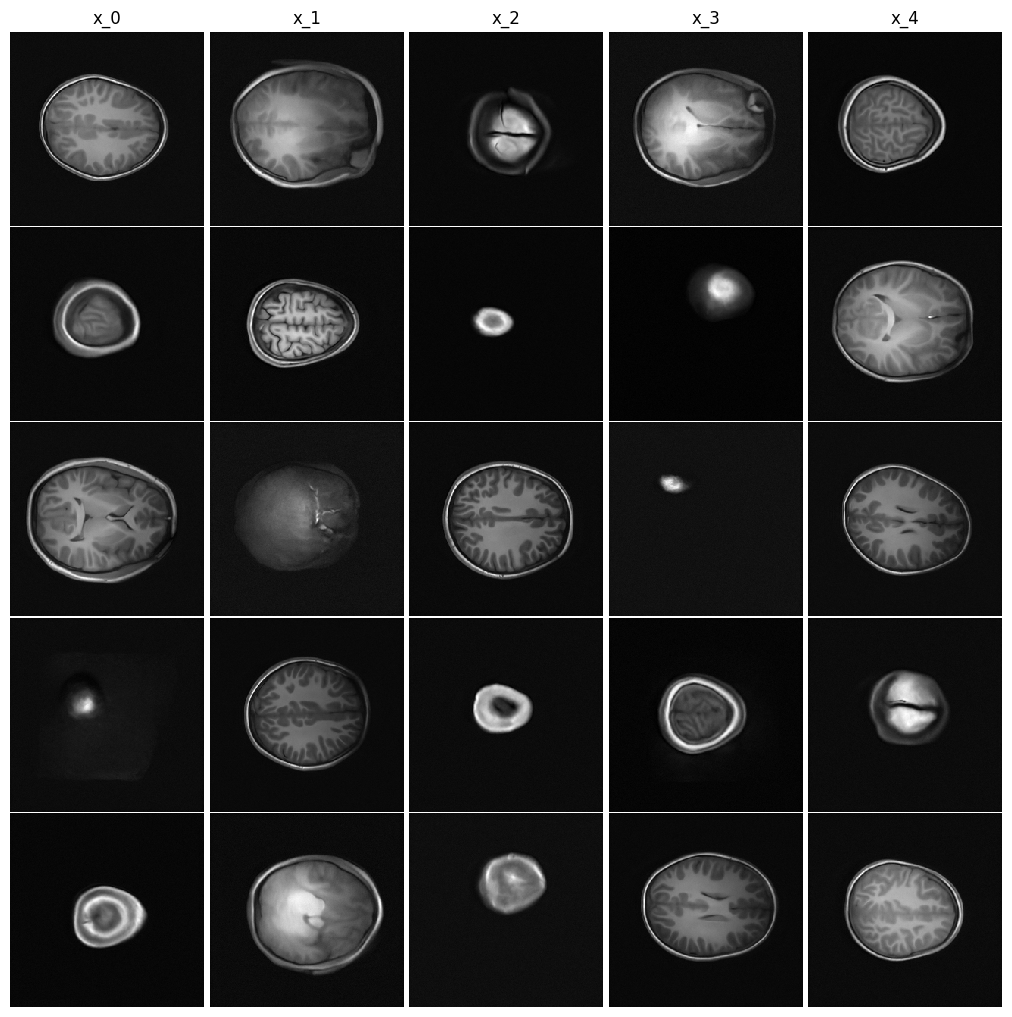

In [6]:
grid_x=5
grid_y=5
a_sampler.steps=3
samples_n, samples  = a_sampler.ancestral_sampler(grid_x*grid_y, 3)

images = samples[-1]
images = np.abs(utils.float2cplx(images))

fig, axss = plt.subplots(grid_x, grid_y, figsize=(10, 10), gridspec_kw={'width_ratios': [1  for _ in range(grid_x)]})
for i in range(grid_x):
    for j in range(grid_y):
        if i==0:
            strs='x_%d'%j
        else:
            strs=''
        axplot(axss[i,j], images[i*grid_y+j], title=strs, vmax=np.max(images[i*grid_y+j]))
plt.tight_layout(pad=.1)